In [1]:
# insert rickroll here ayyye

In [2]:
import csv
import os

import matplotlib
import requests
import pandas as pd
import tabula.io
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from statistics import mean
from matplotlib import cm

Part 1: Data collection/curation + parsing

We have decided to use two sets of data for this project, each involving many countries around the world: gun ownership,
and a collection of homicide rates. The number of guns possessed by civilians in each country cannot stand alone as an indicator of gun violence, as people
kill other people--guns do not.

The gun ownership data originated from smallarmssurvey.org, an organization that
maintains databases on small arms-related statistics worldwide: violent deaths, firearms holdings, etc. We felt that the
data, given the organization's focus on impartial analysis, would be thorough and well-researched.

The homicide rate data originated from the United Nations Office on Drugs and Crime. We shouldn't need to expand on their
reputation, but the data appears to be extremely thorough.

NOTE: should we look for suicide by gun rates, too? What about population?

In [3]:
# opening the homicide rate file
#NOTE: not sure how to scrape this one off the internet, so downloaded data manually and stuck inside the project
homicide_rates = pd.read_csv('united_nations_homicide_rate_by_mechanisms.csv')

#opening the gun ownership data
url = "http://www.smallarmssurvey.org/fileadmin/docs/Weapons_and_Markets/Tools/Firearms_holdings/SAS-BP-Civilian-held-firearms-annexe.pdf"
got_gun = tabula.io.read_pdf(url, output_format='dataframe', pages='all')

#rename columns
got_gun[0].columns=['country_code', 'country', 'region', 'subregion', 'population', 'total_est_guns', 'est_of_guns_per_100_ppl', 'delete1', 'comp_method', 'registered_guns', 'delete2', 'unregistered_guns']

#drop some unnecessary columns & rows
got_gun[0].drop(range(0,5), inplace=True)
got_gun[0].drop(columns=['delete1', 'delete2', 'comp_method', 'registered_guns', 'unregistered_guns'], inplace=True)

got_gun[0]

,country_code,country,region,subregion,population,total_est_guns,est_of_guns_per_100_ppl
5,AFG,Afghanistan,Asia,Southern Asia,"34,169,000","4,270,000",12.5
6,ALB,Albania,Europe,Southern Europe,"2,911,000","350,000",12.0
7,DZA,Algeria,Africa,Northern Africa,"41,064,000","877,000",2.1
8,ASM,American Samoa,Oceania,Polynesia,"56,000",400,0.7
9,AND,Andorra,Europe,Southern Europe,"69,000","10,000",14.1
...,...,...,...,...,...,...,...
266,VGB,Virgin Islands (U.K.),Americas,Caribbean,"31,000",300,0.8
267,VIR,Virgin Islands (U.S.),Americas,Caribbean,"107,000","18,000",16.6
268,YEM,Yemen,Asia,Western Asia,"28,120,000","14,859,000",52.8
269,ZMB,Zambia,Africa,Eastern Africa,"17,238,000","158,000",0.9


Part 2: Data management/representation

In [4]:
#is this actually doing anything? all the data looks the same as got_gun[0]
regions = homicide_rates['Region'].unique()
rows = []
for row in got_gun[0].iterrows():
    if row[1]['region'] in regions and row[1]['total_est_guns'] != '-':
        rows.append(row[1])
gun_owners = pd.DataFrame(rows)
gun_owners

,country_code,country,region,subregion,population,total_est_guns,est_of_guns_per_100_ppl
5,AFG,Afghanistan,Asia,Southern Asia,"34,169,000","4,270,000",12.5
6,ALB,Albania,Europe,Southern Europe,"2,911,000","350,000",12.0
7,DZA,Algeria,Africa,Northern Africa,"41,064,000","877,000",2.1
8,ASM,American Samoa,Oceania,Polynesia,"56,000",400,0.7
9,AND,Andorra,Europe,Southern Europe,"69,000","10,000",14.1
...,...,...,...,...,...,...,...
266,VGB,Virgin Islands (U.K.),Americas,Caribbean,"31,000",300,0.8
267,VIR,Virgin Islands (U.S.),Americas,Caribbean,"107,000","18,000",16.6
268,YEM,Yemen,Asia,Western Asia,"28,120,000","14,859,000",52.8
269,ZMB,Zambia,Africa,Eastern Africa,"17,238,000","158,000",0.9


In [5]:
# adding a column for guns per 100k citizens into dataframe
per_100k = []
for row in gun_owners.iterrows():
    val = (float(row[1]['total_est_guns'].replace(",", "")) / float(row[1]['population'].replace(",", ""))) * 100000
    per_100k.append(round(val, 2))
gun_owners['guns_per_100k'] = per_100k
gun_owners

,country_code,country,region,subregion,population,total_est_guns,est_of_guns_per_100_ppl,guns_per_100k
5,AFG,Afghanistan,Asia,Southern Asia,"34,169,000","4,270,000",12.5,12496.71
6,ALB,Albania,Europe,Southern Europe,"2,911,000","350,000",12.0,12023.36
7,DZA,Algeria,Africa,Northern Africa,"41,064,000","877,000",2.1,2135.69
8,ASM,American Samoa,Oceania,Polynesia,"56,000",400,0.7,714.29
9,AND,Andorra,Europe,Southern Europe,"69,000","10,000",14.1,14492.75
...,...,...,...,...,...,...,...,...
266,VGB,Virgin Islands (U.K.),Americas,Caribbean,"31,000",300,0.8,967.74
267,VIR,Virgin Islands (U.S.),Americas,Caribbean,"107,000","18,000",16.6,16822.43
268,YEM,Yemen,Asia,Western Asia,"28,120,000","14,859,000",52.8,52841.39
269,ZMB,Zambia,Africa,Eastern Africa,"17,238,000","158,000",0.9,916.58


In [6]:
#what is this slice of code doing?
guns_per_region = {}
for reg in gun_owners['region'].unique():
    guns_per_region[reg] = pd.DataFrame(gun_owners.loc[gun_owners['region'] == reg])

#if we're using a different homicide table, we can scrub this code right?
years = {}
for y in homicide_rates['Year'].unique():
    rates = []
    data = homicide_rates.loc[homicide_rates['Year'] == y]
    for row in data.iterrows():
        val = str(row[1]['rate']).replace(",", "")
        val = float(val)
        rates.append(val)
    years[y] = mean(rates)

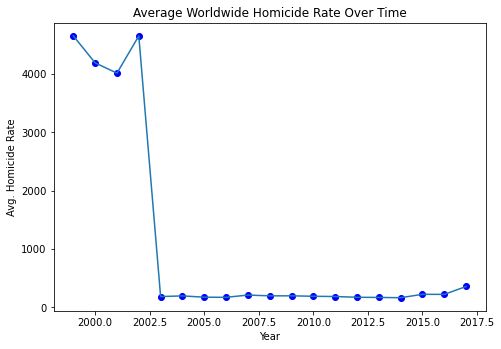

In [7]:
x_year = list(years.keys())
y_val = list(years.values())

fig=plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.scatter(x_year, y_val, color="b")
ax.plot(x_year, y_val)

ax.set_xlabel("Year")
ax.set_ylabel("Avg. Homicide Rate")
ax.set_title("Average Worldwide Homicide Rate Over Time")
plt.show()

#todo - do a graph showing the average over all years for a country, just to see what it looks like

In [8]:
pop = {}
guns = {}
for key in guns_per_region.keys():
    table = guns_per_region[key]
    total_pop = {}
    total_gun = {}
    for row in table.iterrows():
        total_pop[row[1]['country_code']] = int(row[1]['population'].replace(",", ""))
        total_gun[row[1]['country_code']] = float(row[1]['total_est_guns'].replace(",", ""))
    pop[key] = total_pop
    guns[key] = total_gun

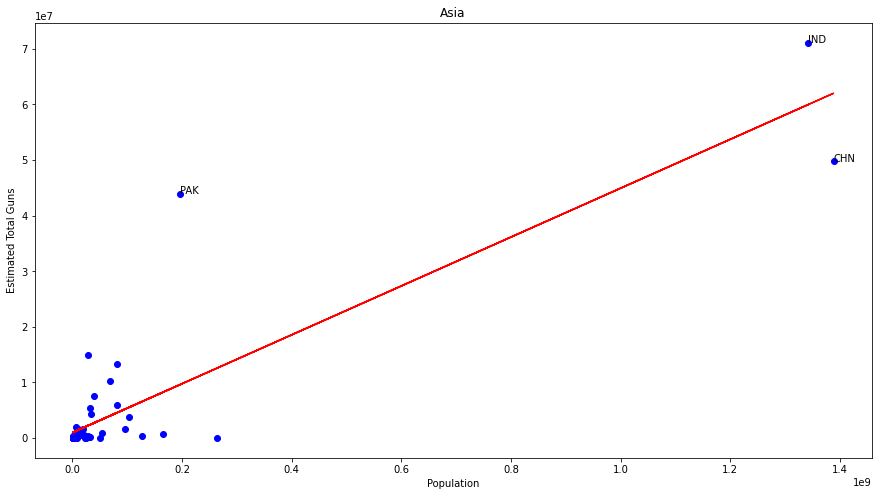

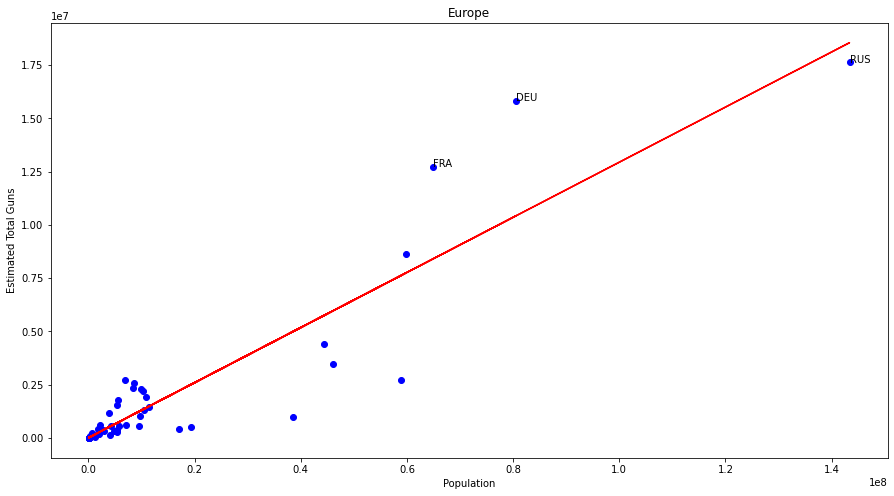

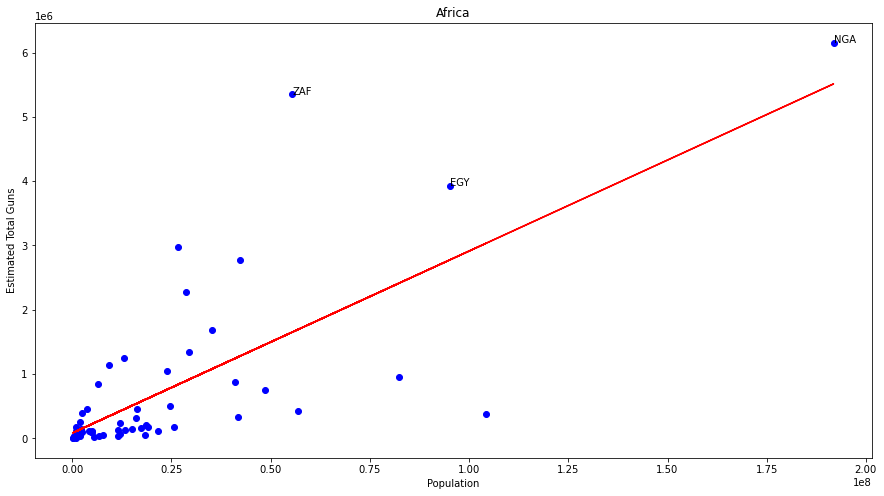

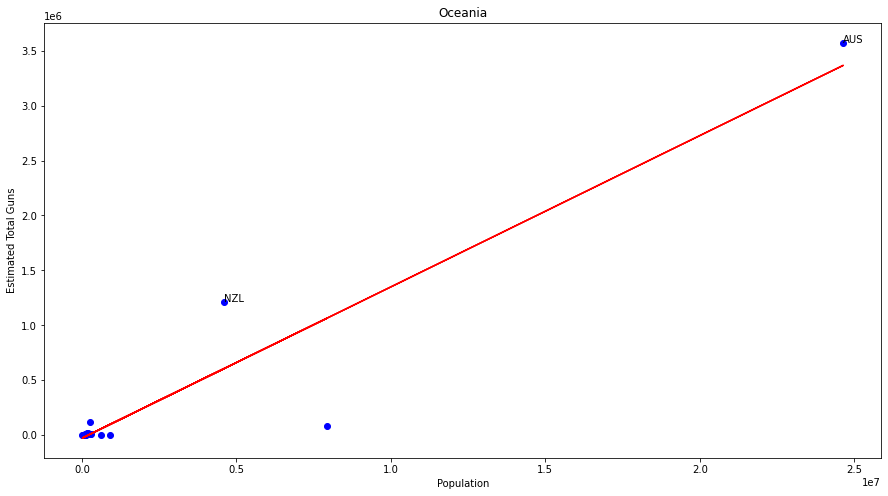

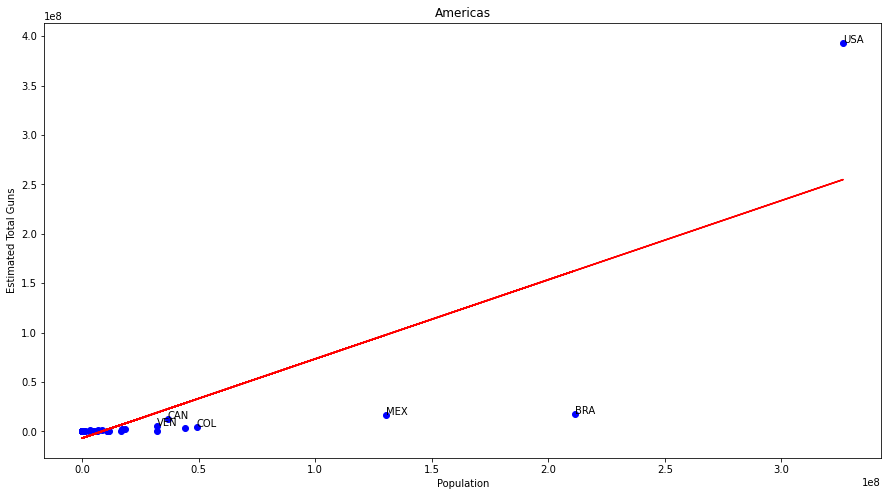

In [9]:
titles = list(guns_per_region.keys())
thresholds = {'Asia': 40000000, 'Europe': 10000000, 'Africa': 3000000, 'Oceania': 1000000, 'Americas': 4500000}
check_guns = {}
for i in titles:
    x = (np.array(list(pop[i].values())))
    y = (np.array(list(guns[i].values())))
    #m, b = np.polyfit(x,y,1)

    plt.figure(figsize=(15, 8))
    plt.scatter(x, y, color="Blue")
    #plt.plot(x, (m*x) + b, color="Red")

    # I moved this up here
    regr = LinearRegression()

    regr.fit(x.reshape(-1, 1), y.reshape(-1, 1))
    plt.plot(x.reshape(-1, 1), regr.predict(x.reshape(-1, 1)), color="Red")

    plt.xlabel("Population")
    plt.ylabel("Estimated Total Guns")
    plt.title(i)

    #highlight the top few countries of interest
    #NOTE: is not working yet
    """if i == 'Asia':
        print(guns[i])
        print(pop[i])
        #if guns > 200000 && population > 200000 b/c that's 1 gun to every person???
        #if guns[i] > pop[i]:
        plt.scatter(x,y, color = 'Purple')
        #print("country:", i, "population:", pop[i], "guns:", guns[i])
        # maybe stick those top few countries into a dataframe for later use??"""

    # NOTE: This puts the text only in certain ones -- the thresholds are defined above. Not sure if it's a problem that they're hardcoded but ¯\_(ツ)_/¯ 
    for j in pop[i].keys():
        if guns[i][j] >= thresholds[i]:
            if not check_guns.get(i, False):
                check_guns[i] = []
            check_guns[i].append(j)
            plt.text(x=pop[i][j], y=guns[i][j], s=j)
    plt.show()

In [10]:
guns = {}
guns_per = {}
for key in guns_per_region.keys():
    table = guns_per_region[key]
    total_pop = {}
    total_gun = {}
    for row in table.iterrows():
        total_pop[row[1]['country_code']] = int(row[1]['population'].replace(",", ""))
        total_gun[row[1]['country_code']] = row[1]['guns_per_100k']
    guns[key] = total_pop
    guns_per[key] = total_gun

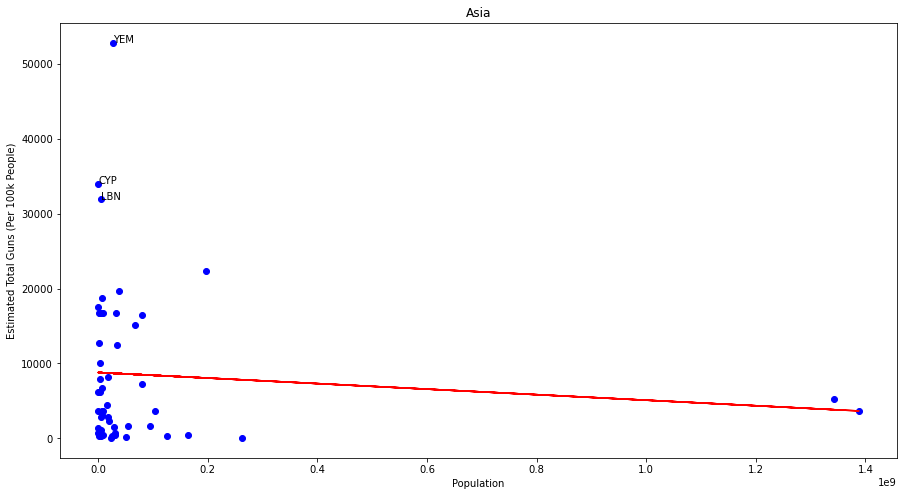

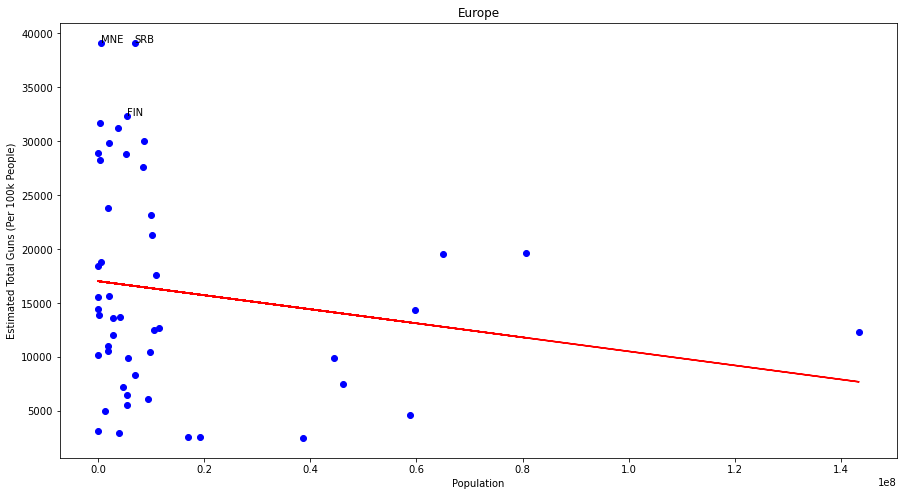

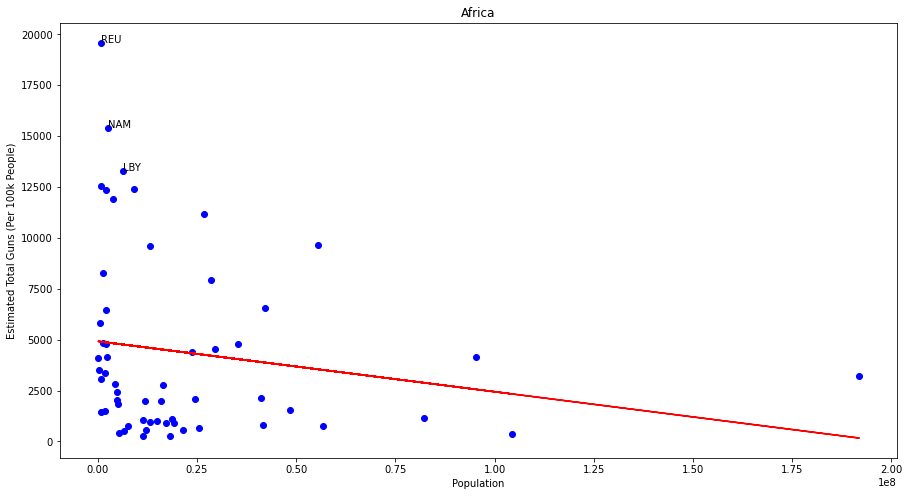

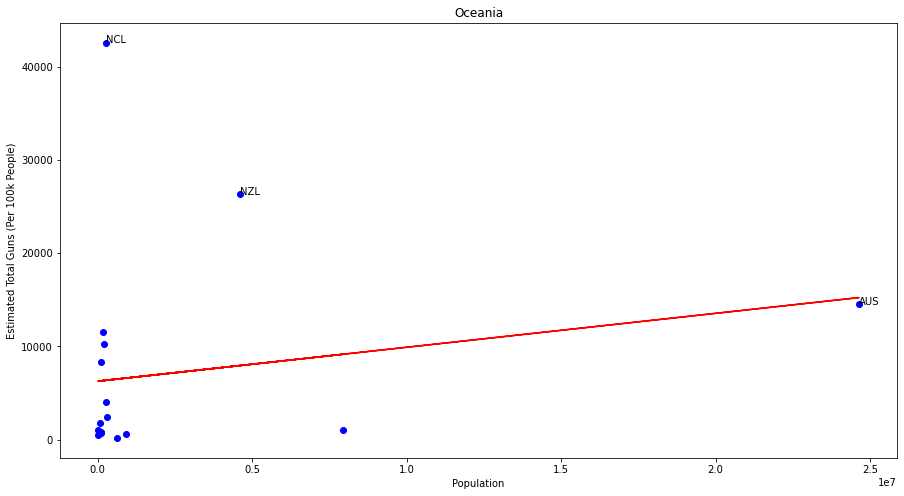

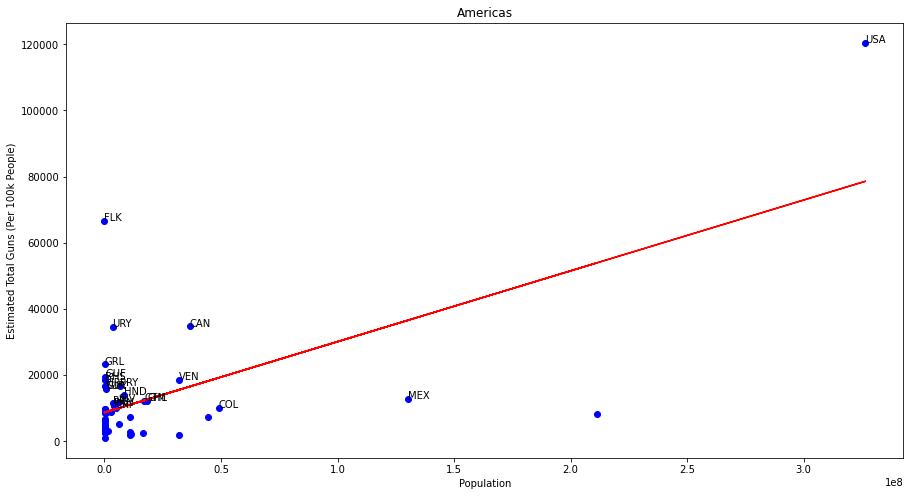

In [11]:
titles = list(guns_per_region.keys())
thresholds = {'Asia': 30000, 'Europe': 32000, 'Africa': 13000, 'Oceania': 14000, 'Americas': 10000}
check_guns_per = {}
for i in titles:
    x = (np.array(list(guns[i].values())))
    y = (np.array(list(guns_per[i].values())))

    plt.figure(figsize=(15, 8))
    plt.scatter(x, y, color="Blue")
    
    regr = LinearRegression()

    regr.fit(x.reshape(-1, 1), y.reshape(-1, 1))
    plt.plot(x.reshape(-1, 1), regr.predict(x.reshape(-1, 1)), color="Red")

    plt.xlabel("Population")
    plt.ylabel("Estimated Total Guns (Per 100k People)")
    plt.title(i)

    for j in guns[i].keys():
        if guns_per[i][j] >= thresholds[i]:
            if not check_guns_per.get(i, False):
                check_guns_per[i] = []
            check_guns_per[i].append(j)
            plt.text(x=guns[i][j], y=guns_per[i][j], s=j)
    plt.show()

In [12]:
# TODO -- Found this link: https://www.indexmundi.com/facts/indicators/VC.IHR.PSRC.P5/rankings/middle-east -- has different links to more tables per region but would need to do a couple of different scrapes per region due to how the site is divied up, or could just do the one tab for the whole world (Look at bottom of table and the links to the other tables are just below it). Next on my to do list

In [13]:
gun_owners.loc[gun_owners['country_code'] == 'REU']

,country_code,country,region,subregion,population,total_est_guns,est_of_guns_per_100_ppl,guns_per_100k
198,REU,Réunion,Africa,Eastern Africa,"873,000","171,000",19.6,19587.63


In [14]:
# This is just the table of every country in the world, not organized by region

r = requests.get('https://www.indexmundi.com/facts/indicators/VC.IHR.PSRC.P5/rankings')
homs = pd.read_html(r.text)[0].drop(['Rank'], axis=1)
homs.loc[homs['Year'] == 2017]

,Country,Value,Year
0,El Salvador,61.8,2017
1,Jamaica,57.0,2017
3,Honduras,41.7,2017
5,Belize,37.9,2017
7,South Africa,35.9,2017
...,...,...,...
161,Luxembourg,0.3,2017
162,"Macao SAR, China",0.3,2017
163,"Hong Kong SAR, China",0.3,2017
164,Singapore,0.2,2017


In [15]:
# Thinking of using this data to make a graph that shows, for each of the highest gun-per-people countries, how much correlation that guns-per-people as on intentional homicides per people

In [16]:
guns_per = {}
hom_rates = {}
for key in check_guns_per.keys():
    to_use = check_guns_per[key]
    for country in to_use:
        ser = gun_owners.loc[gun_owners['country_code'] == country]
        name = ser['country'][ser.index[0]]
        if len(homs.loc[homs['Country'] == name].index) > 0:
            guns_per[country] = ser['guns_per_100k'][ser.index[0]]
            ser2 = homs.loc[homs['Country'] == name]
            hom_rates[country] = ser2['Value'][ser2.index[0]]
    '''


    table = table.loc[table['country_code'] in check_guns_per[key]]
    total_gun = {}
    total_hom = {}
    for row in table.iterrows():
        country = row[1]['country']
        ser = homs.loc[homs['Country'] == country]
        if len(ser.index) > 0:
            total_gun[row[1]['country_code']] = float(row[1]['guns_per_100k'].replace(",", ""))
            total_hom[row[1]['country_code']] = float(ser['Value'][ser.index])
    guns_per[key] = total_gun
    hom_rates[key] = total_hom
hom_rates'''

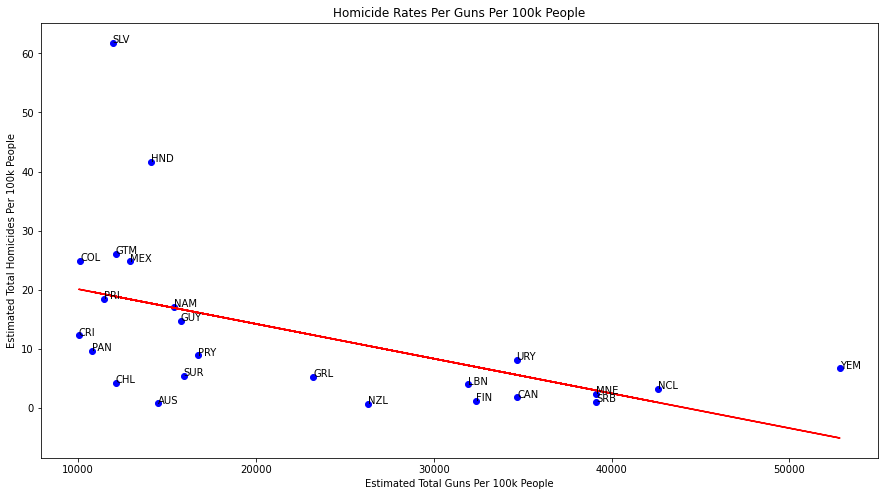

In [17]:
g = (np.array(list(guns_per.values())))
h = (np.array(list(hom_rates.values())))

plt.figure(figsize=(15, 8))
plt.scatter(g, h, color="Blue")
    
regr = LinearRegression()

regr.fit(g.reshape(-1, 1), h.reshape(-1, 1))
plt.plot(g.reshape(-1, 1), regr.predict(g.reshape(-1, 1)), color="Red")

plt.xlabel("Estimated Total Guns Per 100k People")
plt.ylabel("Estimated Total Homicides Per 100k People")
plt.title("Homicide Rates Per Guns Per 100k People")

for j in guns_per.keys():
    plt.text(x=guns_per[j], y=hom_rates[j], s=j)
plt.show()

In [18]:
# TODO -- Left off here (mrp)

Part 3: Exploratory data analysis

In [19]:
#stuff

Part 4: Hypothesis testing & machine learning

In [20]:
#wat

Part 5: Communication of insights attained

In [21]:
#um